In [2]:
from astropy.io import fits

ff = fits.open('ngc6101/hlsp_hugs_hst_acs-wfc_ngc6101_f814w_v1_stack-0340s.fits')
print(ff)

In [3]:
im_data = ff[0].data
#print(im_data)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

'''
plt.figure()
plt.imshow(im_data, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()
'''

"\nplt.figure()\nplt.imshow(im_data, origin='lower', norm=LogNorm(), cmap='Greys')\nplt.colorbar()\nplt.show()\n"

In [5]:
ff.info()

Filename: ngc6101/hlsp_hugs_hst_acs-wfc_ngc6101_f814w_v1_stack-0340s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (10000, 10000)   float32   


In [6]:
#section1 = im_data[2400:2600, 5650:5950]
#section1 = im_data[3000:3600, 5000:5600]
section1 = im_data[2000:8000, 2000:8000]
'''
plt.figure()
plt.imshow(section1, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()
'''

"\nplt.figure()\nplt.imshow(section1, origin='lower', norm=LogNorm(), cmap='Greys')\nplt.colorbar()\nplt.show()\n"

In [7]:
from astropy.stats import sigma_clipped_stats 

mean, median, std = sigma_clipped_stats(section1, sigma= 3.0)
print(mean, median, std)

3.8396626 0.0 12.6173


In [8]:
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std)
sources1 = daofind(section1 - median)
for col in sources1.colnames:
    if col not in ('id', 'npix'):
        sources1[col].info.format = '%.2f'

#sources1.pprint(max_width = 76)

In [9]:
import numpy as np 
from photutils.aperture import CircularAperture

positions = np.transpose((sources1['xcentroid'], sources1['ycentroid']))
apertures = CircularAperture(positions, r=5.0)

'''
plt.imshow(section1, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
'''

"\nplt.imshow(section1, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')\napertures.plot(color='red', lw=1.5, alpha=0.5);\n"

In [10]:
print(apertures)

Aperture: CircularAperture
positions: [[ 601.2242334 ,  104.93407169],
            [ 626.68003625,  107.3576764 ],
            [ 762.46899285,  116.07197171],
            ...,
            [4886.53185924, 5997.57124448],
            [5063.12651047, 5997.81566685],
            [5291.41290676, 5997.45549515]]
r: 5.0


In [11]:
from photutils.aperture import CircularAnnulus, ApertureStats, aperture_photometry

annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

'''
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
annulus_aperture.plot(color='yellow', lw=1.5, alpha=0.3);
'''

"\nplt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')\napertures.plot(color='red', lw=1.5, alpha=0.5);\nannulus_aperture.plot(color='yellow', lw=1.5, alpha=0.3);\n"

In [12]:
aper_stats = ApertureStats(section1, annulus_aperture)
bkg_mean = aper_stats.mean
aper_area = apertures.area_overlap(section1)
total_bkg = bkg_mean*aper_area
star_data = aperture_photometry(section1, apertures)

star_data['total_bkg'] = total_bkg
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'

star_data.pprint()

  id   xcenter   ycenter  aperture_sum total_bkg 
         pix       pix                           
----- --------- --------- ------------ ----------
    1 601.22423 104.93407    20224.441 -248.77586
    2 626.68004 107.35768    2460.0027 -296.57274
    3 762.46899 116.07197    10589.729  85.369366
    4 891.56925 116.72317    6008.2722 -86.333844
    5 663.67008 121.15749    998.88824 -12.990046
    6 717.22239 122.09163    1093.9148 -322.59577
    7 965.76455 122.63216    1633.0109 -157.27747
    8 631.25887  123.4736    1528.9998 -332.34533
    9 893.85507 126.16495    1014.0252  287.04907
  ...       ...       ...          ...        ...
64650 4614.3839 5992.8303     3082.157  12232.797
64651 5140.9769 5993.0492     3421.302  2113.4079
64652 5219.2602 5994.3818    13510.894   5504.984
64653  4471.976 5997.4321    44859.585  1719.3235
64654 4554.1969   5997.62    1913705.7  8353.3359
64655 4558.6582 5998.0487    1361119.7  10295.855
64656  4578.384 5998.0492    3375.6132  3883.5623


In [13]:
from acstools import acszpt

#date = 2006-05-31 , 14:42:25
#exposure time = 35s
#filter = F606W
#instrument: Hubble Space Telescope: ACS-WFC

date = '2006-05-31'
instrument = 'WFC'
filter = 'F814W'

q = acszpt.Query(date= date, detector = instrument)
zpt_table = q.fetch()
q_filter = acszpt.Query(date=date, detector=instrument,filt=filter)
filter_zpt=q_filter.fetch()

print(filter_zpt)


Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom electron cm2) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F814W   8048.0                     7.018e-20  26.784  25.517  25.948


In [14]:
import math

zeropoint = 25.948
exposure_time = 1900

magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint-(2.4*math.log10(abs(line[3]-line[4])/exposure_time)))
star_data['magnitude'] = magnitudes

star_data.pprint(max_lines=-1, max_width=-1)

  id   xcenter   ycenter  aperture_sum  total_bkg      magnitude     
         pix       pix                                               
----- --------- --------- ------------ ----------- ------------------
    1 601.22423 104.93407    20224.441  -248.77586 23.470162033198044
    2 626.68004 107.35768    2460.0027  -296.57274  25.56012092996113
    3 762.46899 116.07197    10589.729   85.369366 24.165721640718676
    4 891.56925 116.72317    6008.2722  -86.333844  24.73313911117343
    5 663.67008 121.15749    998.88824  -12.990046 26.604700781238577
    6 717.22239 122.09163    1093.9148  -322.59577 26.254081082141635
    7 965.76455 122.63216    1633.0109  -157.27747 26.009993484898505
    8 631.25887  123.4736    1528.9998  -332.34533  25.96942406695075
    9 893.85507 126.16495    1014.0252   287.04907 26.949360267025664
   10 613.51774 128.93114    3142.9756  -327.85339  25.31996892376814
   11 783.93351 128.96811    1462.3105   12.390505 26.229782934612622
   12 768.06151 130.

17.92321367445644	34.66805616215022	24.53402728307508	2.154937932685262


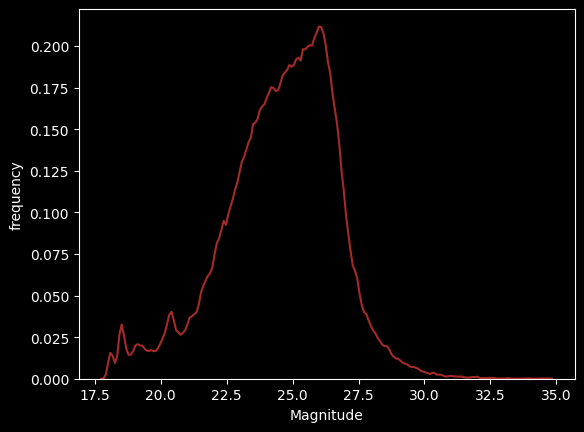

In [16]:
import seaborn as sns
import pandas as pd

mag_min = np.min(magnitudes)
mag_max = np.max(magnitudes)
mag_mid = np.mean(magnitudes)
mag_std = np.std(magnitudes)

print(f'{mag_min}\t{mag_max}\t{mag_mid}\t{mag_std}')

plt.style.use('dark_background')
mag_df = pd.DataFrame(magnitudes, columns=['Magnitude'])
fig, ax1 = plt.subplots()
ax1.set_ylabel('Density')
#sns.histplot(data=mag_df, x='Magnitude', binwidth=0.5, color='orange', ax=ax1)
#ax2 = ax1.twinx()

sns.kdeplot(data=mag_df, x='Magnitude', bw_adjust=0.25, color='brown', ax=ax1)
ax1.set_ylabel('frequency')
ax1.grid(False)
plt.show()
